In [ ]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
#!git clone https://github.com/Kaggle/kaggle-environments.git
#!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v6 https://github.com/Georgemouts/football.git #https://github.com/google-research/football.git  
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.com/ubuntu 

In [ ]:
#from gfootball.env.football_env import FootballEnv
#from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import utils
import random
from collections import deque
import matplotlib.pyplot as plt

import gym
import gfootball 
import math
import os
import utils


In [ ]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')

new_observation,reward,done,info = env.step(5)
print(new_observation)

[ 0.         -0.          0.         -0.          1.0110294   0.
 -0.          0.          0.02       -0.          0.11059734 -0.
  0.         -0.00191829  1.          0.          0.        ]


In [ ]:
class ReplayBuffer(object):
  def __init__(self,max_size,input_shape,n_actions):
    self.mem_size = max_size
    self.mem_cntr= 0 
    self.state_memory =np.zeros((self.mem_size,*input_shape),dtype=np.float32)
    self.new_state_memory = np.zeros((self.mem_size,*input_shape),dtype=np.float32)
    self.action_memory = np.zeros(self.mem_size,dtype = np.int64)
    self.reward_memory = np.zeros(self.mem_size,dtype=np.float32)
    self.terminal_memory = np.zeros(self.mem_size , dtype = np.uint8)

  def store_transition(self,state,action,reward,new_state,done):
    index=self.mem_cntr % self.mem_size

    self.state_memory[index] = state
    self.new_state_memory[index] = new_state
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    
    self.terminal_memory[index]=done

    self.mem_cntr += 1

  def sample_buffer(self,batch_size):
    max_mem = min(self.mem_cntr,self.mem_size)
    batch = np.random.choice(max_mem,batch_size,replace=False)
    
    states = self.state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    new_states = self.new_state_memory[batch]
    dones = self.terminal_memory[batch]

    return states, actions, rewards ,new_states ,dones

In [ ]:
class DuelingLinearDeepQNetwork(nn.Module):
  def __init__(self, ALPHA, n_actions , name , input_dims , chkpt_dir ='tmp/dueling_dqn'):
    super(DuelingLinearDeepQNetwork,self).__init__()

    self.fc1 = nn.Linear(*input_dims,230)
    self.fc2 =nn.Linear(230,230)
    self.V =nn.Linear(230,1)
    self.A=nn.Linear(230,n_actions)
    
    self.optimizer = optim.Adam(self.parameters() , lr =ALPHA)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)
    self.checkpoint_dir = chkpt_dir
    self.checkpoint_file = os.path.join(self.checkpoint_dir,name+'dueling_dqn')

  def forward(self,state):
    l1 = F.relu(self.fc1(state))
    l2 = F.relu(self.fc2(l1))
    V= self.V(l2)
    A= self.A(l2)

    return V,A

  def save_checkpoint(self):
    print('save checkpoint ...')
    T.save(self.state_dict(),self.checkpoint_file)


  def load_checkpoint(self):
    print('load checkpoint ...')
    self.load_state_dict(T.load(self.checkpoint_file))

In [ ]:
class Agent(object):
  def __init__(self,gamma,epsilon,alpha,n_actions,input_dims,mem_size,batch_size,eps_min=0.01,eps_dec = 5e-7,replace =1000,chkpt_dir = 'tmp/dueling_dqn'):

    self.gamma = gamma 
    self.epsilon=epsilon
    self.eps_min=eps_min
    self.eps_dec=eps_dec
    self.action_space =[i for i in range(n_actions)]
    self.learn_step_counter = 0
    self.replace_target_cnt = replace
    self.batch_size=batch_size

    self.memory = ReplayBuffer(mem_size,input_dims,n_actions)
    self.q_eval = DuelingLinearDeepQNetwork(alpha,n_actions,input_dims=input_dims,name='q_eval' , chkpt_dir =chkpt_dir )

    self.q_next = DuelingLinearDeepQNetwork(alpha,n_actions,input_dims=input_dims,name='q_next' , chkpt_dir =chkpt_dir )


  def store_transition(self,state,action,reward, state_ , done):
    self.memory.store_transition(state,action,reward, state_ , done)

  def choose_action(self,observation):
    if np.random.random() > self.epsilon :
        observation = observation[np.newaxis, :]
        state = T.tensor(observation).to(self.q_eval.device)
        _,advantage =self.q_eval.forward(state)
        action = T.argmax(advantage).item()
    else:
        action = np.random.choice(self.action_space)
    return action

  def replace_target_network(self):
      if self.replace_target_cnt is not None and self.learn_step_counter % self.replace_target_cnt == 0:
        self.q_next.load_state_dict(self.q_eval.state_dict())
      
  def decrement_epsilon(self):
      self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

  
  def learn(self):
      if self.memory.mem_cntr  <self.batch_size:
        return
      
      self.q_eval.optimizer.zero_grad()
      self.replace_target_network()

      state,action,reward,new_state,done =self.memory.sample_buffer(self.batch_size)

      state=T.tensor(state).to(self.q_eval.device)
      new_state = T.tensor(new_state).to(self.q_eval.device)
      action = T.tensor(action).to(self.q_eval.device)
      reward = T.tensor(reward).to(self.q_eval.device)
      dones= T.tensor(done).to(self.q_eval.device)

      V_s,A_s = self.q_eval.forward(state)
      V_s_ ,A_s_ = self.q_next.forward(new_state)

      q_pred = T.add(V_s,(A_s-A_s.mean(dim=1 , keepdim=True))).gather(1,action.unsqueeze(-1)).squeeze(-1)

      q_next = T.add(V_s_,(A_s_-A_s_.mean(dim=1 , keepdim=True)))

      q_target = reward + self.gamma*T.max(q_next , dim=1)[0].detach()
      q_target[dones] = 0.0

      loss = self.q_eval.loss(q_target,q_pred).to(self.q_eval.device)
      loss.backward()
      self.q_eval.optimizer.step()
      self.learn_step_counter +=1

      self.decrement_epsilon()

  def save_models(self):
      self.q_eval.save_checkpoint()
      self.q_next.save_checkpoint()

  def load_models(self):
      self.q_eval.load_checkpoint()
      self.q_next.load_checkpoint()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1581.)


---Avg reward last 10:  -3.7448820664809 Avg score last 10:  0.3 Avg steps 79.9 episode= 10 ---
---Avg reward last 10:  -1.2301537342932896 Avg score last 10:  0.4 Avg steps 92.8 episode= 20 ---
---Avg reward last 10:  -1.666033496722402 Avg score last 10:  0.3 Avg steps 89.1 episode= 30 ---
---Avg reward last 10:  0.483029796461717 Avg score last 10:  0.7 Avg steps 100.3 episode= 40 ---
---Avg reward last 10:  1.0389524985800171 Avg score last 10:  0.7 Avg steps 100.8 episode= 50 ---
Last 50 episodes avg score 0.48


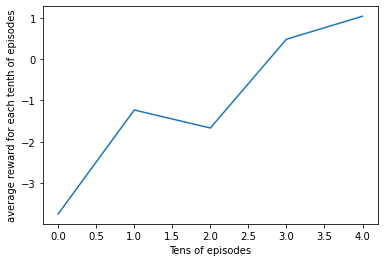

---Avg reward last 10:  0.9662512465883296 Avg score last 10:  0.6 Avg steps 101.1 episode= 60 ---
---Avg reward last 10:  0.547096448689382 Avg score last 10:  0.6 Avg steps 93.2 episode= 70 ---
---Avg reward last 10:  -1.4021312465102618 Avg score last 10:  0.1 Avg steps 80.3 episode= 80 ---
---Avg reward last 10:  0.07032861936625748 Avg score last 10:  0.5 Avg steps 99.1 episode= 90 ---
---Avg reward last 10:  0.6524869082525078 Avg score last 10:  0.8 Avg steps 102.8 episode= 100 ---


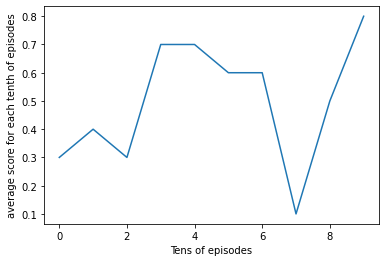

Last 50 episodes avg score 0.52


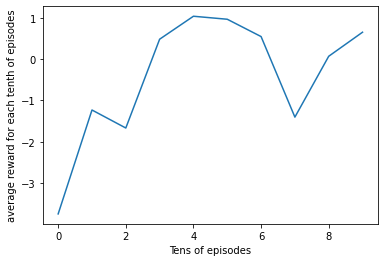

END OF TRAINING
Last 50 episodes avg score 0.52


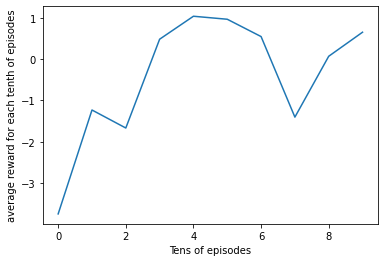

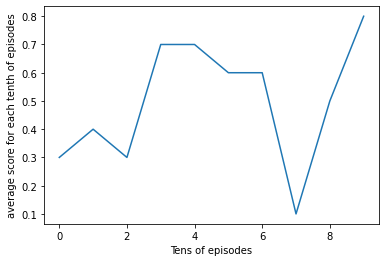

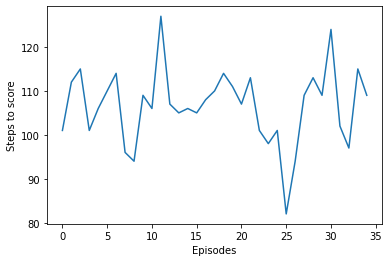

FINAL SCORE PERCENTAGE 0.52


In [ ]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 115 states 


#CUSTOMIZE ACTION LIST AND OBSERVATIONS
Action_list=[4,5,6,12,13,14,15,17,18]
#print(env.action_space.n)
#Create Objects


agent=Agent(gamma=0.99 , epsilon = 1.0 , alpha = 0.00115 , input_dims = [17] , n_actions = len(Action_list) ,mem_size =1000000,eps_min=0.01,batch_size =64 
                  ,eps_dec=1e-3 , replace =100)
all_prints = All_prints()
#cus_rew =Custom_Rewards()

scores,ep_history =[],[]

steps=0
terminal =0 # an skorarei se pano apo enan arithmo paixnidion stamatao tin ekpaideysi 
episode =0
shout =0


num_of_eps = 20001
eps_rew=0
rew_list =[]
score_list = []
step_list =[]
goal_steps=[]
avg_score_list = []
avg_rew_list =[]
steal = []
steps_to_goal = []
for i in range(num_of_eps) : 
  score =0 
  done=False 
  eps_rew=0
  observation =env.reset()
  #print("Pinakas apo observations",observation)
  act =0 #first action will be to move right 
  shout=0 #mporei na kanei shout 1 fora se kathe ep
  timer=0 # an klepsei tin mpala kai tin kratisei pano apo 4 steps stamata
  forward=0 #an perasei ton antipalo kai kanei sprint tin proti fora  einai +5
  sprint=0 # an kanei tin proti fora sprint + 20
  dribble =0 # tin proti fora poy kanei dribble na pairnei +10
  fault =0
  checkpoint_reward=[1,1,1,1,1]
  steps=0
  reward =0 

  while not done:

    #CUSTOMIZE ACTIONS HERE 
   
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i) SOSTO
    #print("------------")

    #print(observation[0],observation[1],observation[2],observation[3],observation[4],observation[5])
    

   
     
      
 
    if(act ==0 ): # proti praksi ena bima deksia
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      
      act=1
      #print(new_observation)
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    #CUSTOM ACTIONS
    action = agent.choose_action(observation) # from 1-9s which is index to action list

    #while((observation[4]> observation[0] )  and (Action_list[action]==13 or Action_list[action]==15) and observation[14]==1): #den kanei sprint prin perasei ton paikti
     # action = agent.choose_action(observation)

    #while(observation[4] - observation[0] >0.2 and observation[4]-observation[0]>0 and (Action_list[action]==17 or Action_list[action]==18 )):
     # action = agent.choose_action(observation)

    while((observation[0] > observation[4] +0.02)  and (Action_list[action]==17 or Action_list[action]==18 )): # an ton perasei min kanei drible 
      action = agent.choose_action(observation)
    while((observation[0]<0.65)  and (Action_list[action]==12)): #Den kanei shout ektos periohis
      action = agent.choose_action(observation)


    if(shout==0):   #ama kanei shout na min kanei tipota meta 
      new_observation,reward,done,info = env.step(Action_list[action])
      
      if(Action_list[action]==12):
        #print("EKANE SHOUT")
        shout=1
    else:
      #print("MPIKE STO ELSE")
      new_observation,reward,done,info = env.step(0)
      action=0 #Ta parakato if den pianoun to Action_list[action]=12 alla gia Action_list[action]=4

#CUSTOM REWARDS-------------------------------
    if(done ==1 and reward ==1): #if agent scores , wins +50
      #print("goal","episode",i,"step=",steps)
      reward += 60
      steps_to_goal.append(steps)
   
    if(done ==1 and reward == 0): # an bgei i mpala apo ton antipalo einai -15 , a bgei apo ton paikti einai -5 
      if(shout ==1 ):
        reward = reward - 10
        #print("Ball is out by player - 5")
        terminal =0
      else:
        if(observation[9] <0.4 or observation[9] >-0.4 ):
          #print("FAUL-SCORE =+1")
          fault =1
          
        else:
          reward = reward -20 #12
          #print("ball is out -15","episode",i,"Ball Position",observation[8],observation[9],observation[10],"step=",steps)
          terminal =0



      terminal= terminal +1
      


    if(observation[16]==1 ):  # an klepsei tin mpala kai tin kratisei pano apo 4 steps stamata
      #print("antipalos")
      timer=timer+1
      reward = reward - 20 #30
      
     
      if(timer == 2 ):
        reward = reward - 30#40
        
        terminal =0
      if (timer>2 and timer <  4 ):
        reward = reward - 40 #50
        #print("antipalos")
        
      if (timer>4 and timer <6 ):
        reward = reward - 50
        #print("klepsimo")
        done =1
      if(timer >= 8):
        done=1
        reward = reward -20
        #print("klepsimo")

    if(observation[8]< 0.0 ):  #An i mpala paei piso apo to kentro telos paixnidiou
      #print("Mpala piso apo kentro")
      reward = reward-35
      done =1 

    if(observation[9]>0.35 or observation[9]<-0.35):
      reward = reward - 35
      #print("mpala ektos orion")
      done = 1

    #----------------
    if(observation[14]== 0): #an den exo stin katoxi tin mpala einai -5
      reward =reward-5
    #if(observation[14] == 1): # an exo tin katoxi na einai +2
     #reward =reward +5

    if ((observation[8] > observation[0] + 0.05) and (observation[9] - observation[1] <=0.03) or(observation[9] - observation[1] >=-0.03) ) and Action_list[action]==5: #an kanei deksia kai exei ti mpala
      reward = reward + 5
          
  
    if(observation[16]==1):
      reward = reward - 10

    if(observation[4] - observation[0] > 0.2 and Action_list[action]==5): # an einai makria o antipalos kai kano bima deksia +2
        reward =reward + 2
    if(observation[4] - observation[0] > 0.2 and (Action_list[action] == 14 or Action_list[action] == 15 or Action_list[action] == 18 )): # an meinei akinitos  einai -2
        reward = reward - 5

    #----------------

    if((observation[4]-observation[0]< 0.05)and dribble==0 and (observation[4]-observation[0]> 0) and (Action_list[action]==17)):  # an kanei dirbble konta ston antipalo prin erthei se ayton +15 
      #print("dribble prin ton antipalo")
      if(dribble==0):
        dribble =1
        reward = reward + 20



    if(((observation[0] > observation [4] + 0.05) and observation[14]== 1 ) and done!= 1 and shout ==0 and (observation [0]>-0.2 or observation[0]<0.2)):  # an perasei ton antipalo einai +5
      reward = reward + 8
      if(forward ==0):
        forward =1
        reward = reward + 25
                            

    if((observation[4] < observation[0] -0.08)and sprint== 0 and observation[8] <0.65 and done != 1 and shout ==0 and  (Action_list[action]==13 or Action_list[action]==15) and observation[14]==1 and (observation[1]>-0.2 or observation[1]<0.2)):
       reward = reward + 20
       sprint=1
  

    if((observation[0]<0.65)  and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      reward= reward -200
      done=1
      #print("shout ektos periohis","episode",i,"step=",steps)
      
    if((observation[0]>0.65) and (Action_list[action]==12) and observation[0]<0.75 and observation[0] >observation[4] +0.01 ): #an shoutarei mesa ti megali periohi +10
      reward= reward + 25
   
    

    
    reward = reward - ( math.sqrt( ((0.935 - observation[8])**2) + (0 -observation[9])**2 ) *0.3) #oso pio makria einai toso perissotero xanei

    #END OF CUSTOM REWARDS ----------------------------- 
 
    
   
    score+= reward/11

    
    
    if(fault==1 and done ==1):
      reward =25

    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    eps_rew += reward

#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------

  
  #eps_rew+=reward
  step_list.append(steps)
  

  val = info.values()
  list_val=list(val)
  if(fault == 1):
    f=[1]
    list_val =list(f)

  score_list.append(list_val)
  #print(score_list)

  rew_list.append(eps_rew/steps)
  episode = episode +1 

  #print("---Episode reward:", eps_rew/steps ,"score",list_val,"steps",steps,"episode=",i,"---")

  #TERMINATE 
  if ((abs(np.mean(score_list[-50:]) - np.mean(score_list[-100:])) < 0.04) and (abs(np.mean(score_list[-100:]) - np.mean(score_list[-200:]))<0.03) and  i>100):
    print("END OF TRAINING")
    break
    

# PRINTS
  if ((i % 10)== 0  and i!=0):

      print("---Avg reward last 10: ", np.mean(rew_list[-10:]),"Avg score last 10: ",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      avg_score_list.append(np.mean(score_list[-10:]))
      avg_rew_list.append(np.mean(rew_list[-10:]))
      #print(score_list)

  if (((i % 100)== 0) and i!=0) :
     plt.plot(avg_score_list)
     plt.xlabel('Tens of episodes')
     plt.ylabel('average score for each tenth of episodes')
     plt.plot()
     plt.show()
  if(((i%50)==0) and i!=0):
     print("Last 50 episodes avg score",(np.mean(score_list[-50:])))
     plt.plot(avg_rew_list)
     plt.xlabel('Tens of episodes')
     plt.ylabel('average reward for each tenth of episodes')
     plt.plot()
     plt.show()

 
     
  #EPISODE PRINTS

print("Last 50 episodes avg score",(np.mean(score_list[-50:])))
plt.plot(avg_rew_list)
plt.xlabel('Tens of episodes')
plt.ylabel('average reward for each tenth of episodes')
plt.plot()
plt.show()

plt.plot(avg_score_list)
plt.xlabel('Tens of episodes')
plt.ylabel('average score for each tenth of episodes')
plt.plot()
plt.show()


plt.plot(steps_to_goal)
plt.xlabel('Episodes')
plt.ylabel('Steps to score')
plt.plot()
plt.show()

print("FINAL SCORE PERCENTAGE",np.mean(score_list[-50:]))